# Catchment hydrological model with 1-parameter

Let's use a very simple hydrological model that estimates the daily outflow of from a catchment as a function of the daily rainfall falling on the catchment area. The catchment of study is covered by both urban and agricultural land and has a surface area **A = 500 ha**

![lumped model](util/Lumped_model.png).

The model consists of a single equation to estimate the daily outflow $Q$ (m3/day):

$Q = R * 0.001 * A * C$

where $R$ is the daily rainfall (mm/day), $A$ is the catchment area (m2) and $C$ is the unique model parameter and which is unitless (-)

The first thing, as always, is to import the Python libraries that we are going to need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact # to create interactive elements and figures

!git clone https://github.com/AndresPenuela/UCO_Hydrology_and_Erosion.git # this is to clone the repository on Google Colab
# In this way we can load files contained in the repository such as data file

## Load data
We have **observed daily rainfall (mm/day), daily evapotranspiration (etp; mm/day) and outflow or runoff (m3/day) data from 2010 to 2019** in a Excel file that we are going to load and save as a variable called `obs_data`

In [2]:
obs_data = pd.read_excel('UCO_Hydrology_and_Erosion/Runoff_generation/datos/data example 2.xlsx',index_col = 'date')
obs_data # to print the data on screen

,rain,etp,outflow
date,,,
2010-01-01,1.270,1.168133,6531.84
2010-01-02,2.032,0.262242,6531.84
2010-01-03,25.654,0.991814,74995.20
2010-01-04,13.462,0.808446,33868.80
2010-01-05,24.638,0.849716,101606.40
...,...,...,...
2019-12-28,0.000,0.200841,9918.72
2019-12-29,0.000,0.738878,8951.04
2019-12-30,0.000,0.848909,8467.20


Let's **plot the observed rainfall rate** of one specific year, for example **2018**

Text(0.5, 1.0, 'Hyetograph')

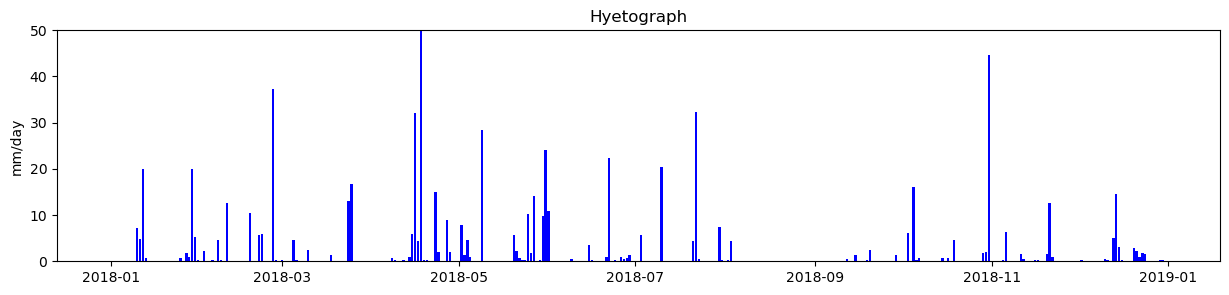

In [3]:
year_of_study = 2018
obs_data_year = obs_data[obs_data.index.year == year_of_study] # to select only data from to the year that we want to study
plt.figure(figsize=(15,3)) # to define the plot size
plt.bar(obs_data_year.index, obs_data_year['rain'], color = 'blue')
plt.ylabel('mm/day')
plt.ylim([0,50])
plt.title('Hyetograph')

And the **observed runoff rate** of **2018**

Text(0.5, 1.0, 'Hydrograph')

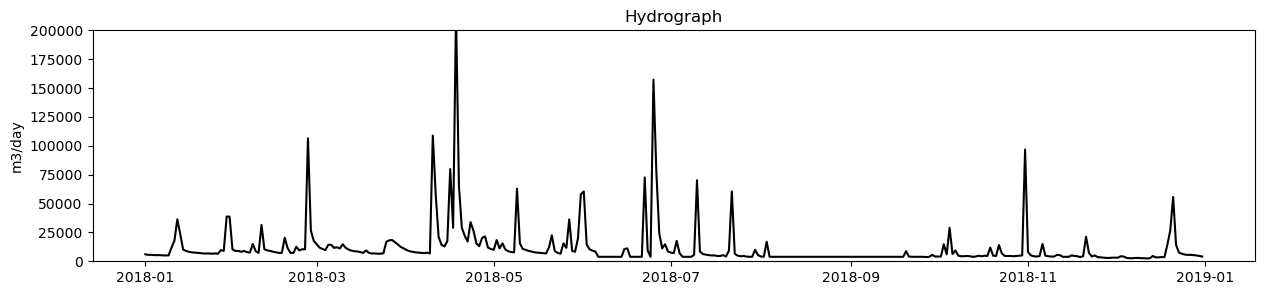

In [4]:
plt.figure(figsize=(15,3)) # to define the plot size
plt.plot(obs_data_year.index, obs_data_year['outflow'], color = 'black')
plt.ylabel('m3/day')
plt.ylim([0,200000])
plt.title('Hydrograph')

Now, let's create our **model**. For this purpose we define a function called *hydro_model*

In [5]:
def hydro_model(R,A,C): # model inputs are always between ()
    
    Q = R*0.001 * A * C # equation to estimate the catchment outflow Q. Note: 0.001 is to transform the rainfall (mm) into m    
    
    return Q

We run the model we have just created by calling the function and defining the inputs

In [6]:
# Inputs
A = 500 * 10000 # ha to m2
C = 0.5
# Create an empty dataframe where we will save the model results
sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
sim_data_year['rain'] = obs_data_year['rain']
# Run the model
sim_data_year['outflow'] = hydro_model(sim_data_year['rain'], A, C)
# Show results
sim_data_year

,rain,outflow
date,,
2018-01-01,0.000,0.0
2018-01-02,0.000,0.0
2018-01-03,0.000,0.0
2018-01-04,0.000,0.0
2018-01-05,0.000,0.0
...,...,...
2018-12-27,0.000,0.0
2018-12-28,0.000,0.0
2018-12-29,0.254,635.0


Now we can compare the observed data with the model results by plotting both time series

## Goodness-of-fit
To measure if the simulated values with a model are close to the observed data values we use googness-of-fit indicators. We are going to see three: the root mean squared error, the Nash-Sutcliffe efficiency and the coefficient of determination 

### Root mean squared error (RMSE)
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance. It has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response. 

$RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(sim_{i} - obs_{i})^{2}}$

### Nash-Sutcliffe efficiency (NSE)
The NSE indicates how well the plot of observed versus simulated data fits the 1:1 line. Nash-Sutcliffe efficiencies range from -Inf to 1. Essentially, the closer to 1, the more accurate the model is. -) NSE = 1, corresponds to a perfect match of modelled to the observed data.

Let's create two functions to compute RMSE and NSE

$NSE = 1 - \frac{\sum_{i=1}^{n}(sim_{i} - obs_{i})^{2}}{\sum_{i=1}^{n}(obs_{i} - \overline{obs})^{2}}$

In [7]:
def RMSE_function(obs,sim):
    
    RMSE = np.sqrt(((sim - obs) ** 2).mean())
    return RMSE

def NSE_function(obs,sim):
    NSE = (1 - (sum((sim - obs) ** 2) / sum((obs - np.mean(obs))**2)))
    
    return NSE

RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])

### Calibration of the hydrological model
A hydrological model usually has a large number of parameters. The user is the one who decides the value of these parameters for a particular application based on the information and data we have about the parameters. Normally we will not have direct measurements of the values of these parameters, but it is likely that we will have historical climatic data and river flow (historical hydrograph of the river). With these data we can infer the values of the parameters by finding the values that make the model result better fit the historical hydrograph of the river, this is called **calibration** of the model.

The easiest way to do this is to change the parameter values one at a time and see how this changes the model output and how well it fits the historical hydrograph.

In [8]:
@interact(C = (0,1,0.05), year_of_study = range(2010,2020))
def interactive_figure_1(C = 0, year_of_study = 2010):

    obs_data_year = obs_data[obs_data.index.year == year_of_study] # to select only data from to the year that we want to study
    
    # Create an empty dataframe where we will save the model results
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    # Run the model
    sim_data_year['outflow'] = hydro_model(sim_data_year['rain'], A, C)

    RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    
    fig, ax = plt.subplots(2,1,figsize=(15,3),sharex = True)
    ax[0].bar(obs_data_year.index,obs_data_year['rain'],color = 'blue',label = 'rain')
    ax[0].set(ylabel='mm/day')
    ax[0].legend()
    ax[1].plot(obs_data_year.index,obs_data_year['outflow'],color = 'black',label = 'obs')
    ax[1].plot(sim_data_year.index,sim_data_year['outflow'],color = 'darkblue', label = 'sim', alpha = 0.6)
    ax[1].set(ylabel='m3/day', ylim = [0,150000])
    ax[1].set_title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,2)))
    ax[1].legend()

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0, step=0.05), Dropdown(description='year_…

### Questions
- Is this a good hydrological model? why?
- Does it represent the main hydrological processes that take place in the catchment?
- What does the parameter C represents?
- Would you define this model as a black-box model or a conceptual model?
- What is the best value of C for all the years of study?
- Which goodness-of-fit coefficient is better, RMSE or NSE?